# Подключение библиотек + нормализация датасетов

In [112]:
#Отключаем все возможные сообщения с различными предупреждениями:
import warnings
warnings.filterwarnings("ignore")

#Для работы с массивами и таблицами:
import numpy as np
import pandas as pd

#Для визуализаиции:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab #Чтобы рисовать сразу несколько графиков в окне.

#графики в svg выглядят более четкими:
%config InlineBackend.figure_format = 'svg' 
%pylab inline


#Увеличиваем стандартный размер графиков:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from scipy import stats
import statsmodels.api as sm

from itertools import product
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


In [38]:
#Считываем обучающую и тестовую выборки.
train_data = pd.read_excel("training.xlsx").rename(columns = {'Date': 'date', 'Value': 'value'})
test_data  = pd.read_excel("testing.xlsx").rename(columns = {'Date': 'date', 'Value': 'value'})

#Приводим даты к целочисленному значению. (Образуются "отрицательные" даты - дело в том, что функция считает 0 - 1970 год)
train_data['date'] = pd.to_datetime(train_data['date']).astype(int)/ 10**10
test_data['date']  = pd.to_datetime(test_data['date']).astype(int)/ 10**10 

test_data['date']  = (test_data['date'] - train_data['date'].mean()) / train_data['date'].std()#Нормируем по статистикам посчитанным по трейну, всё верно! Делаем "до", потому что полсе они изменятся.
train_data['date'] = (train_data['date'] - train_data['date'].mean()) / train_data['date'].std()

In [39]:
train_data.head()
#test_data.head()

,date,value
0,-1.724661,22.8331
1,-1.714874,23.2802
2,-1.706034,23.6156
3,-1.696248,24.1186
4,-1.686777,24.4820


In [40]:
#Информация о датасетах:
print("-"*30)
for dataset in [train_data, test_data]:
  if (dataset.date[0] == train_data.date[0]):
    print("Train:\n")
  else:
    print("Test:\n")
  print("Amount of samples: ", dataset.shape[0])
  print("mean value: ", "%.3f" % dataset.value.mean())
  print("std value:  ", "%.3f" % dataset.value.std())
  print("mean date: ", "%.3f" % dataset.date.mean())
  print("std date:  ", "%.3f" % dataset.date.std())
  print("-"*30)

------------------------------
Train:

Amount of samples:  360
mean value:  43.347
std value:   11.446
mean date:  0.000
std date:   1.000
------------------------------
Test:

Amount of samples:  60
mean value:  65.253
std value:   1.569
mean date:  2.018
std date:   0.168
------------------------------


# Визуализация данных

In [41]:
X_train = pd.read_excel("training.xlsx").values.copy()
X_test  = pd.read_excel("testing.xlsx").values.copy()

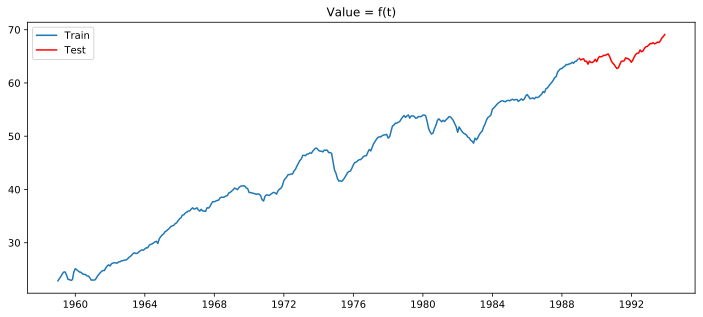

In [42]:
#Matplotlib.
rcParams['figure.figsize'] = 12, 5
plt.plot(X_train[:,0], X_train[:,1], '', label='Train')
plt.plot(X_test[:,0],  X_test[:,1], 'r', label='Test')
plt.legend()
plt.title("Value = f(t)");
#Как видим, значение value достаточно сильно коррелирует со временем.

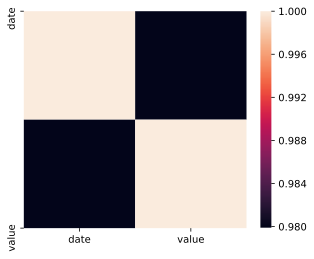

In [43]:
#Seaborn.
rcParams['figure.figsize'] = 5, 4
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix);
#Действительно, корреляция достигает коэффициента 0.98!

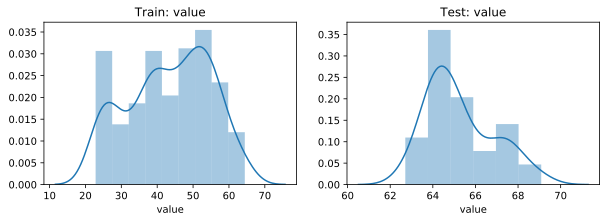

In [44]:
#Pandas'овские методы визуализации + seaborn.
rcParams['figure.figsize'] = 10, 3

pylab.subplot (1, 2, 1)
#train_data['value'].hist(figsize=(10,2));
sns.distplot(train_data.value);
plt.title("Train: value");

pylab.subplot (1, 2, 2)
#test_data['value'].hist(figsize=(6,2));
sns.distplot(test_data.value);
plt.title("Test: value");

#Думаю будет не лишним еще вглянуть на датасеты под разными углами)
#Гистограмма + распределение. (Интересно, что оно довольно сильно напоминает нормальное...)

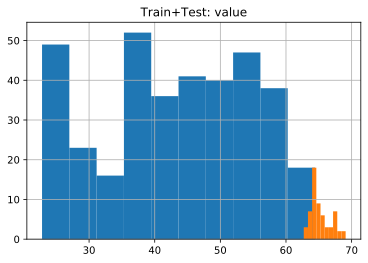

In [45]:
#Pandas'овские методы визуализации.
train_data['value'].hist(figsize=(6,4));
test_data['value'].hist(figsize=(6,4));
plt.title("Train+Test: value");
#Еще раз убеждаемся, что значение, с течением времени, имеют тенденцию к росту.

# 1. Проверка ряда на стационарность посредством визуализации статистик

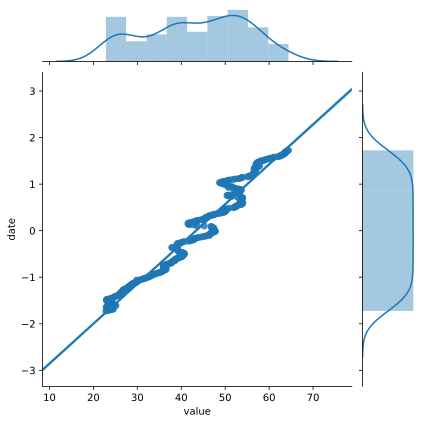

In [46]:
sns.jointplot(x='value', y='date', data=train_data, kind='reg');

Средний разброс скользящего среднего:   10.2998
Средний разброс скользящего отклонения:  0.6364


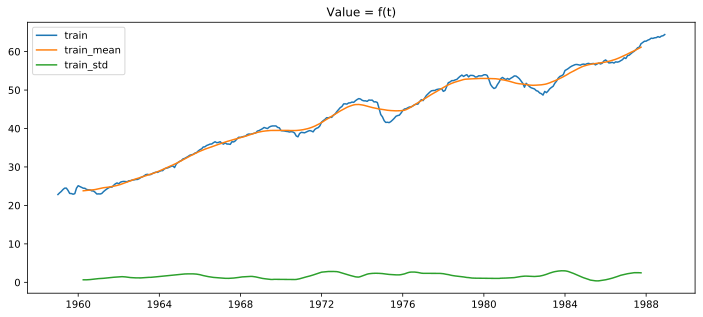

In [47]:
#Matplotlib.
rcParams['figure.figsize'] = 12, 5

window_size = 30

plt.plot(X_train[:,0], X_train[:,1], '', label='train')
plt.plot(X_train[:,0], train_data.value.rolling(window_size, center=True).mean(), label='train_mean')
plt.plot(X_train[:,0], train_data.value.rolling(window_size, center=True).std(),  label='train_std')

plt.legend()
plt.title("Value = f(t)");

print("Средний разброс скользящего среднего:  ", "%.4f" % np.std(train_data.value.rolling(window_size, center=True).mean()))
#Т.к. он достаточно большой - мат.ожидание НЕ сохраняется -> НЕстационарность ряда.

print("Средний разброс скользящего отклонения: ", "%.4f" % np.std(train_data.value.rolling(window_size, center=True).std()))
#Т.к. он не большой - дисперсия преймущественно сохраняется -> имеет смысл расмотреть разности 1-го порядка.

#Как видим, посчитанные скользящие статистики показывают НЕстационарность ряда.
plt.show()

Средний разброс скользящего среднего для разностей 1-го порядка:    0.0843
Средний разброс скользящего отклонения для разностей 1-го порядка:  0.1117


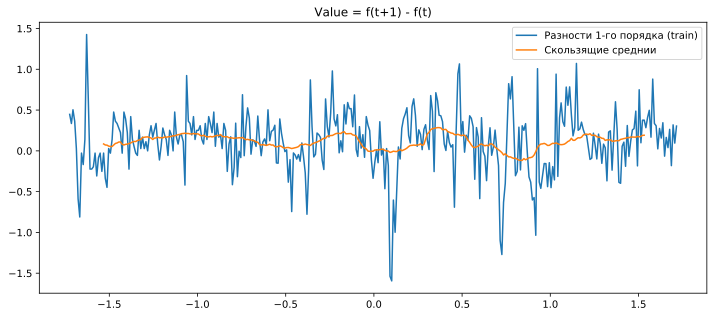

In [80]:
#Matplotlib.
rcParams['figure.figsize'] = 12, 5

ordinary_difference = train_data.value.shift(-1)-train_data.value


plt.plot(X_train[:,0], ordinary_difference, label='Разности 1-го порядка (train)')
plt.plot(X_train[:,0], ordinary_difference.rolling(window_size, center=True).mean(), label='Скользящие среднии')
#plt.plot(X_train[:,0], ordinary_difference.rolling(window_size, center=True).std(),  label='Скользящие отклонения')
plt.legend()
plt.title("Value = f(t+1) - f(t)");

print("Средний разброс скользящего среднего для разностей 1-го порядка:   ", \
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).mean()))

print("Средний разброс скользящего отклонения для разностей 1-го порядка: ", \
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).std()))

#Наблюдаем стационарность разностей первого порядка данного ряда.
plt.show()

# 2.Разложение временного ряда на тренд и сезонность

In [145]:
#Предполгаем, что ряд обладает недостаточно хорошо выраженной сезонностью, вследствии чего будем строить мультипликативную модель, нежели аддитивную.
#(На графиках видно, что амплитуды колебаний не постоянна)

In [146]:
#Класс "Полином" - апроксимирует тренд.
#Подбор параметров происходит посредством градиентного спуска.
#Непосредственно спуск по MSE (Mean Square Error).

#*Не проверял на размерностях > 1*

class poly:
  def __init__(self, degree=1, lr=0.001):
    #Задаем желаемую степень полинома и learning rate.
    self.degree = degree
    self.dim = -1
    self.lr = lr
    self.MSE = -1
  
  def score(self):
    return self.MSE

  def fit(self, X_train, y_train, lr=-1):
    #Learning rate можем менять в процессе обучения.
    #Одна итерация метода '.fit()' соответствует одной эпохе - одной "прогонке" обучающей выборке через модель.
    
    if lr > 0:
      self.lr = lr
    
    #Определяем внутринние переменные при первом просмотре обучающей выборки.
    if self.dim < 0:    
      self.X_train = np.concatenate( (X_train, np.array( [[1]]*X_train.shape[0] )), axis=1 ) #dim + bias.
      self.der_matrix = np.array([[1]]*X_train.shape[0])
      for i in range(1,self.degree+1):
        self.der_matrix = np.concatenate( (X_train**i, self.der_matrix), axis=1 )
      self.der_matrix = -self.der_matrix
      self.y_train = y_train

      self.dim = self.der_matrix.shape[1] #dimension of space.
      self.parametrs = np.zeros(self.dim)
      self.grad = np.empty(self.dim)

      print('der_matrix: ', self.der_matrix.shape)
      print('parametrs: ', self.parametrs.shape)

    y_pred = self.predict(X_train)
    self.MSE = ((self.y_train - y_pred)**2).sum()

    err_vect = 2*(self.y_train - y_pred).reshape(1,-1)

    #Считаем градиент в точке и делаем соответсвенно один шаг.
    self.grad = np.dot(err_vect, self.der_matrix).reshape(-1)
    self.parametrs -= self.lr*self.grad

  #Для предсказания одного сэмпла. (*хз, наверное можно убрать уже*)
  def predict_sample(self, test_sample):
    return np.sum(self.parametrs*np.concatenate( ([test_sample], np.array( [1] )), axis=0 ))

  #Основная функция предсказания, подается несколько сэмлов сразу.
  def predict(self, X_test):

    X_vect = np.array([[1]]*X_test.shape[0])
    for i in range(1,self.degree+1):
      X_vect = np.concatenate( (X_test**i, X_vect), axis=1 )

    return np.sum(self.parametrs*X_vect, axis=1)

# Тестирование модели

In [147]:
sample = np.linspace(0,10,100).reshape(-1,1)

In [148]:
X_train = np.array([[0],[1],[3],[3.5],[5],[6],[7],[10]])
y_train = np.array([0.3, 0.8, 3.2, 3, 5.3, 6.1, 5.5, 8.9])

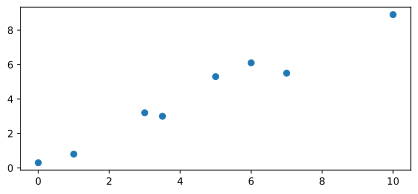

In [149]:
rcParams['figure.figsize'] = 7, 3
plt.plot(X_train, y_train, 'o');

In [150]:
model = poly(degree=0, lr=1e-3)

der_matrix:  (8, 1)
parametrs:  (1,)
63.39692793772726


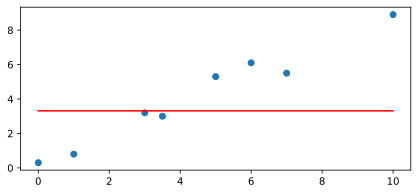

In [55]:
for epoch in range(100):
  model.fit(X_train, y_train, lr=1e-3)
y_pred = np.empty(sample.shape[0])

# for i in range(sample.shape[0]):
#   y_pred[i] = model.predict_sample(sample[i])
y_pred = model.predict(sample)

rcParams['figure.figsize'] = 7, 3
plt.plot(X_train, y_train, 'o');
plt.plot(sample[:,0], y_pred, 'r');
print(model.score())

In [140]:
X_train = train_data.date.values.reshape(-1,1).copy()
y_train = train_data.value.values.copy()

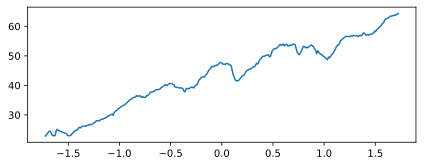

In [141]:
rcParams['figure.figsize'] = 7, 2.5
plt.plot(X_train, y_train, '');

In [142]:
window_size = 20
noize = y_train - train_data.value.rolling(window_size, center=True).mean()
noize[noize.isnull()] = 0
noize = noize.values

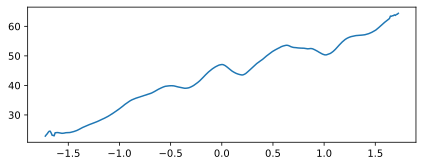

In [143]:
rcParams['figure.figsize'] = 7, 2.5
plt.plot(X_train, y_train - noize, '');

In [144]:
model = poly(degree=2, lr=1e-4)

TypeError: _poly_dispatcher() got an unexpected keyword argument 'degree'

der_matrix:  (360, 3)
parametrs:  (3,)


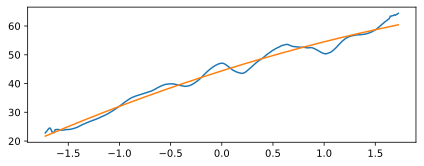

In [61]:
for epoch in range(50000):
  model.fit(X_train, y_train - noize)
y_pred = model.predict(X_train)
plt.plot(X_train, y_train - noize, '');
plt.plot(X_train, y_pred, '');

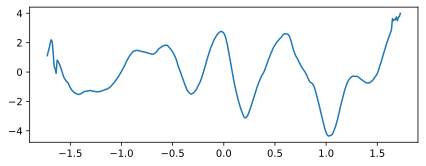

In [62]:
plt.plot(X_train, y_train - y_pred - noize, '');

***Адитивная модель:***

In [63]:
trend = model.predict(X_train)
seasonality = y_train - trend - noize
#noize
(y_train == trend + seasonality + noize).all()

True

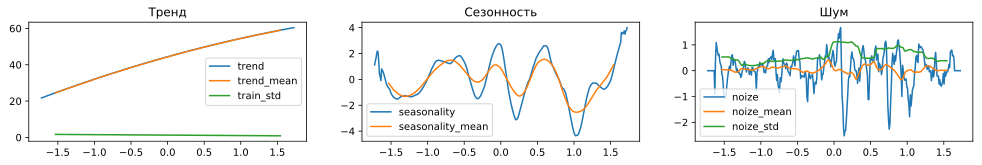

In [64]:
window_size = 40

rcParams['figure.figsize'] = 17, 2.2

pylab.subplot (1, 3, 1)
plt.plot(X_train, trend, '', label='trend')
plt.plot(X_train, pd.Series(trend).rolling(window_size, center=True).mean(), '', label='trend_mean')
plt.plot(X_train, pd.Series(trend).rolling(window_size, center=True).std(), '', label='train_std')
plt.legend()
plt.title('Тренд')

pylab.subplot (1, 3, 2)
plt.plot(X_train, seasonality, '', label='seasonality')
plt.plot(X_train, pd.Series(seasonality).rolling(window_size, center=True).mean(), '', label='seasonality_mean')
#Разкомментрировать, чтобы увидеть на графике скользящее отклонение!
#plt.plot(X_train, pd.Series(seasonality).rolling(window_size, center=True).std(), '', label='seasonality_std')
plt.legend()
plt.title('Сезонность')

pylab.subplot (1, 3, 3)
plt.plot(X_train, noize, '', label='noize')
plt.plot(X_train, pd.Series(noize).rolling(window_size, center=True).mean(), '', label='noize_mean')
plt.plot(X_train, pd.Series(noize).rolling(window_size, center=True).std(), '', label='noize_std')
plt.legend()
plt.title('Шум');

***Мультипликативная модель:***

In [65]:
trend = model.predict(X_train)
seasonality = (y_train - noize) / trend
#noize
"%.5f" % (y_train == trend * seasonality + noize).mean()

'0.86111'

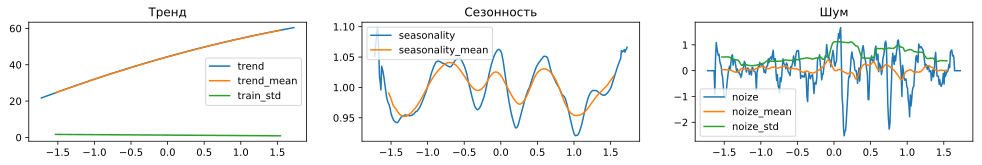

In [66]:
window_size = 40

rcParams['figure.figsize'] = 17, 2.2

pylab.subplot (1, 3, 1)
plt.plot(X_train, trend, '', label='trend')
plt.plot(X_train, pd.Series(trend).rolling(window_size, center=True).mean(), '', label='trend_mean')
plt.plot(X_train, pd.Series(trend).rolling(window_size, center=True).std(), '', label='train_std')
plt.legend()
plt.title('Тренд')

pylab.subplot (1, 3, 2)
plt.plot(X_train, seasonality, '', label='seasonality')
plt.plot(X_train, pd.Series(seasonality).rolling(window_size, center=True).mean(), '', label='seasonality_mean')
#Разкомментрировать, чтобы увидеть на графике скользящее отклонение!
#plt.plot(X_train, pd.Series(seasonality).rolling(window_size, center=True).std(), '', label='seasonality_std')   
plt.legend()
plt.title('Сезонность')

pylab.subplot (1, 3, 3)
plt.plot(X_train, noize, '', label='noize')
plt.plot(X_train, pd.Series(noize).rolling(window_size, center=True).mean(), '', label='noize_mean')
plt.plot(X_train, pd.Series(noize).rolling(window_size, center=True).std(), '', label='noize_std')
plt.legend()
plt.title('Шум');

Вывод: В обоих моделях наблюдается следующее:

- Тренд: НЕстационарный ряд. (Да и не ряд вообще:-) )
- Сезонность: Стационарный ряд.
- Шум: Стационарный ряд.

#***3. Построение прогнозирующей модели:***

Посмотрим на ACF и PACF полученного ряда:

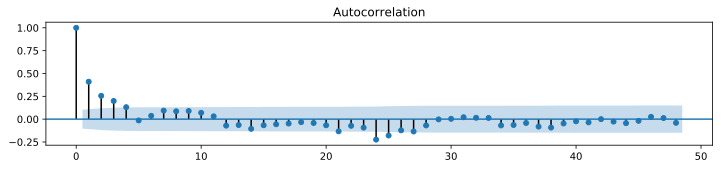

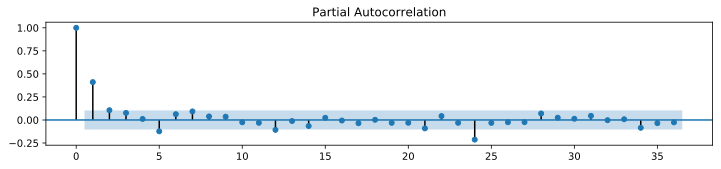

In [82]:
rcParams['figure.figsize'] = 12, 5
seq = pd.read_excel('training.xlsx', index_col=0)
seq.Values = seq.Value - seq.Value.shift(1)
seq.Value.plot()
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(seq.Values[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(seq.Values[1:].values.squeeze(), lags=36, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=3, P=0, p=1

In [84]:
ps = range(0, 2)
d=1
qs = range(0, 4)

In [87]:
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [88]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(seq.Value, order=(param[0], d, param[1])).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

CPU times: user 958 ms, sys: 17.7 ms, total: 976 ms
Wall time: 774 ms


In [89]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


  parameters         aic
5     (1, 1)  255.641355
6     (1, 2)  256.958699
7     (1, 3)  258.926232
4     (1, 0)  263.241050
3     (0, 3)  266.970398


Лучшая модель:

In [91]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  Value   No. Observations:                  360
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -124.821
Date:                Wed, 11 Dec 2019   AIC                            255.641
Time:                        22:28:45   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7400      0.065     11.464      0.000       0.614       0.867
ma.L1         -0.3683      0.080     -4.598      0.000      -0.525      -0.211
sigma2         0.1173      0.006     20.413      0.0

Её остатки:

Критерий Стьюдента: p=0.007619
Критерий Дики-Фуллера: p=0.000000


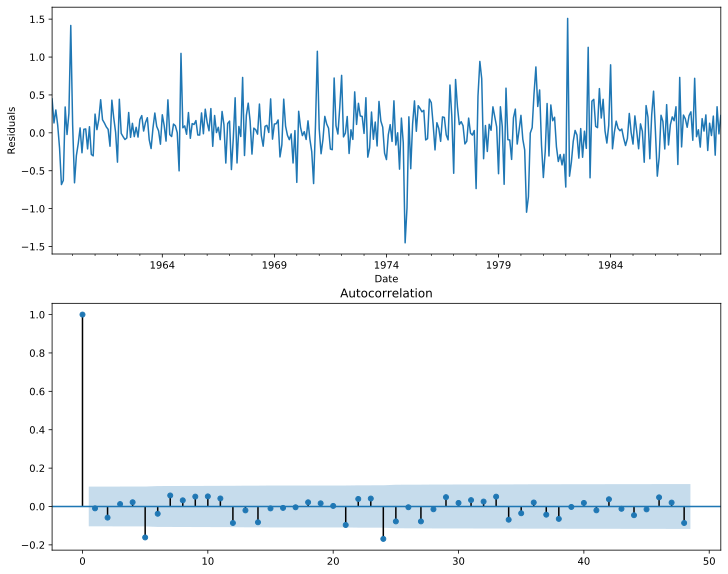

In [108]:
rcParams['figure.figsize'] = 12, 10
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

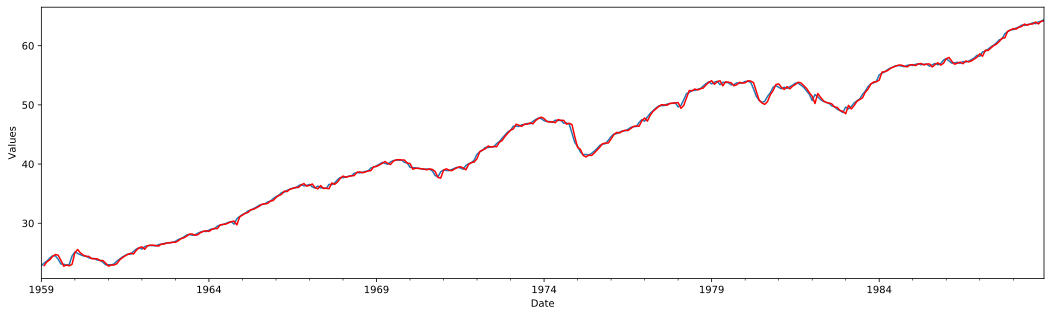

In [107]:
seq['model'] = best_model.fittedvalues
rcParams['figure.figsize'] = 18, 5
seq.Value.plot()
seq.model[1:].plot(color='r')
plt.ylabel('Values')
pylab.show()

### Прогноз

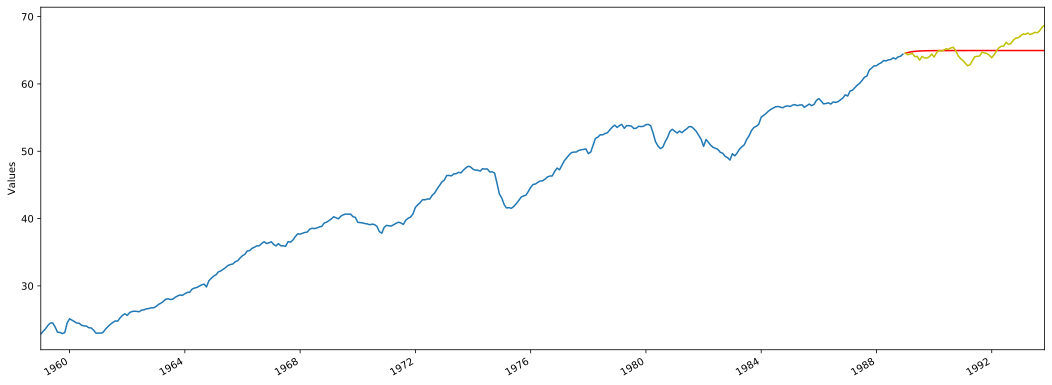

In [139]:
rcParams['figure.figsize'] = 9, 5
seq2 = seq[['Value']]
date_list = [datetime.datetime.strptime("1988-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,60)]
future = pd.DataFrame(index=date_list, columns = seq2.columns)
seq2 = pd.concat([seq2, future])
seq2['forecast'] = best_model.predict(start=360, end=419)

plt.figure(figsize(18,7))
seq2.Value.plot()
seq2.forecast.plot(color='r')
plt.plot(X_test[:,0],  X_test[:,1], 'y', label='Test')
plt.ylabel('Values')
pylab.show()

r2 score:

In [138]:
test_seq = pd.read_excel('testing.xlsx', index_col=0)
print('на тренировочной выборке:', r2_score(seq.Value, best_model.predict(start=0, end=359)))
print('на тестовой выборке:',r2_score(test_seq.Value, best_model.predict(start=360, end=419)))

на тренировочной выборке: 0.9880190074064734
на тестовой выборке: -0.024472075879839572


**Временной ряд является интегрированным порядка k, если его разности порядка k образуют стационарный ряд. Вернемся к вкладке "Визуализация данных" и увидим, что ряд является интегрированным порядка 1**


Средний разброс скользящего среднего для разностей 1-го порядка:    0.1095
Средний разброс скользящего отклонения для разностей 1-го порядка:  0.1183


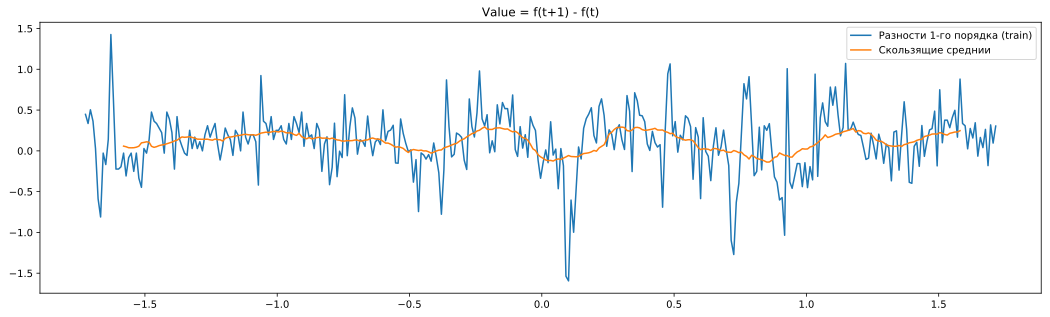

In [106]:
#Matplotlib.
rcParams['figure.figsize'] = 18, 5

window_size = 30
ordinary_difference = train_data.value.shift(-1)-train_data.value

plt.plot(X_train[:,0], ordinary_difference, label='Разности 1-го порядка (train)')
plt.plot(X_train[:,0], ordinary_difference.rolling(window_size, center=True).mean(), label='Скользящие среднии')
#plt.plot(X_train[:,0], ordinary_difference.rolling(window_size, center=True).std(),  label='Скользящие отклонения')
plt.legend()
plt.title("Value = f(t+1) - f(t)");

print("Средний разброс скользящего среднего для разностей 1-го порядка:   ", \
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).mean()))

print("Средний разброс скользящего отклонения для разностей 1-го порядка: ", \
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).std()))

#Наблюдаем стационарность разностей первого порядка данного ряда.